In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from pyearth import Earth
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression
import math
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, BaggingRegressor

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix

np.warnings.filterwarnings('ignore')

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Distribution of response
*By Cindy Wu*

In [27]:
# Note: due to ordering of project code report, some code in subsequent sections 
# might need to be run first (in data preparation section before this)
red_dist = pd.DataFrame(red_train_y.value_counts())
white_dist = pd.DataFrame(white_train_y.value_counts())

standard deviation of red wine:  0.8082071246512386
mean of red wine:  5.63302752293578


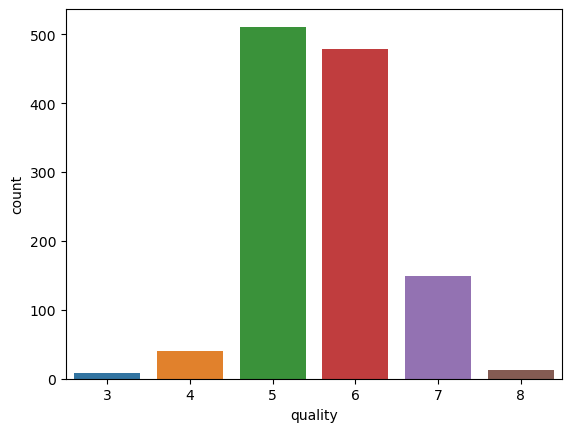

In [21]:
#...Plot for distribution of response (red wine)...#
sns.barplot(x = red_dist.index, y = red_dist['count'])
# Mean and standard deviation of response #
print('standard deviation of red wine: ', red_train_y.std())
print('mean of red wine: ', red_train_y.mean())

standard deviation of red wine:  0.8858234923027732
mean of red wine:  5.878028859243125


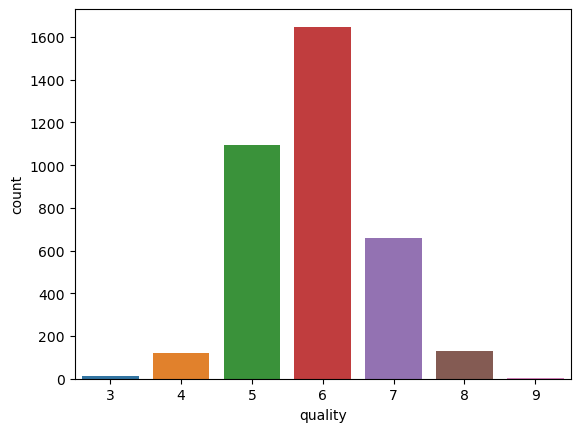

In [22]:
#...Plot for distribution of response (white wine)...#
sns.barplot(x = white_dist.index, y = white_dist['count'])
# Mean and standard deviation of response #
print('standard deviation of red wine: ', white_train_y.std())
print('mean of red wine: ', white_train_y.mean())

standard deviation:  0.8736837515552826
mean of:  5.817733990147783


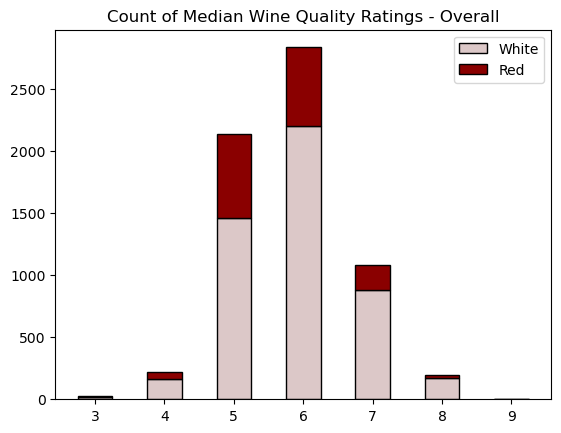

In [26]:
value_counts = red['quality'].value_counts()
value_counts_white = white['quality'].value_counts()
quality = (
3, 4, 5, 6, 7, 8, 9
)
weight_counts = {
    "White": np.array([value_counts_white.iloc[5], value_counts_white.iloc[4], value_counts_white.iloc[1],
                      value_counts_white.iloc[0], value_counts_white.iloc[2], value_counts_white.iloc[3], value_counts_white.iloc[6]]),
        "Red": np.array([value_counts.iloc[5], value_counts.iloc[3], value_counts.iloc[0],
                      value_counts.iloc[1], value_counts.iloc[2], value_counts.iloc[4], 0])
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(len(quality))

colors = {
    "White": (220/255, 200/255, 200/255),  # RGB values for cream white
    "Red": (0.54, 0.0, 0.0)       # RGB values for dark red
}

for boolean, weight_count in weight_counts.items():
    p = ax.bar(quality, weight_count, width, label=boolean, bottom=bottom, color=colors[boolean], edgecolor='black')
    bottom += weight_count

ax.set_title("Count of Median Wine Quality Ratings - Overall")
ax.legend(loc = "upper right")
plt.savefig("response_distribution.png")

print('standard deviation: ', combined_train_y.std())
print('mean of: ', combined_train_y.mean())

plt.show()


### Data Cleaning

In [126]:
missing_values = red.isnull().sum()
print(missing_values)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [127]:
missing_values = white.isnull().sum()
print(missing_values)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Our data had no missing values, the only cleaning done was combining red and white wine datasets. 

### Data preparation
*By Keaton Olds*

In [106]:
#load red and white wine datasets
red = pd.read_csv('winequality-red.csv', delimiter = ';')
white = pd.read_csv('winequality-white.csv', delimiter = ';')

In [107]:
#splite red and white datasets into predictors and response
red_y = red.quality
red_X = red.drop("quality", axis = 1)
white_y = white.quality
white_X = white.drop("quality", axis = 1)

In [108]:
#split red wine predictors and response into train and test, stratifying with respect to the response
red_train_x, red_test_x, red_train_y,\
red_test_y = train_test_split(red_X, red_y, test_size = 0.25, stratify=red_y)

In [109]:
#split whie wine predictors and response into train and test, stratifying with respect to the response
white_train_x, white_test_x, white_train_y,\
white_test_y = train_test_split(white_X, white_y, test_size = 0.25, stratify=white_y)

In [110]:
#create copies of the predictor datasets, and add the 'type' predictor specifying if the wine is red or white
X_train_red_copy = red_train_x.copy()
X_test_red_copy = red_test_x.copy()
X_train_white_copy = white_train_x.copy()
X_test_white_copy = white_test_x.copy()
X_train_red_copy['type'] = 'red'
X_test_red_copy['type'] = 'red'
X_train_white_copy['type'] = 'white'
X_test_white_copy['type'] = 'white'

In [111]:
#combine the copies of red and white wine datasets to form the combined wines dataset
combined_train_x = pd.concat([X_train_red_copy, X_train_white_copy], axis = 0)
combined_train_y = pd.concat([red_train_y, white_train_y])
combined_test_x = pd.concat([X_test_red_copy, X_test_white_copy], axis = 0)
combined_test_y = pd.concat([red_test_y, white_test_y])
combined_train_x = pd.get_dummies(combined_train_x)
combined_test_x = pd.get_dummies(combined_test_x)

In [4]:
#read in the CSVs we created
#NOTE: these are not the CSVs created in this document but the CSVs we used throughout the project to tune our 
#models and to produce the results seen in the presentation
red_train_x = pd.read_csv('red_train_x.csv')
white_train_x = pd.read_csv('white_train_x.csv')
red_train_y = pd.read_csv('red_train_y.csv')
white_train_y = pd.read_csv('white_train_y.csv')
red_test_x = pd.read_csv('red_test_x.csv')
white_test_x = pd.read_csv('white_test_x.csv')
red_test_y = pd.read_csv('red_test_y.csv')
white_test_y = pd.read_csv('white_test_y.csv')
combined_train_x = pd.read_csv("combined_train_x")
combined_train_y = pd.read_csv("combined_train_y")
combined_test_x = pd.read_csv("combined_test_x")
combined_test_y = pd.read_csv("combined_test_y")

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

**MARS:** *Cindy Wu*

In [11]:
combined_train_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
103,8.1,0.575,0.22,2.1,0.077,12.0,65.0,0.99670,3.29,0.51,9.2,1,0
531,11.9,0.380,0.49,2.7,0.098,12.0,42.0,1.00040,3.16,0.61,10.3,1,0
337,7.8,0.430,0.32,2.8,0.080,29.0,58.0,0.99740,3.31,0.64,10.3,1,0
965,8.3,0.340,0.40,2.4,0.065,24.0,48.0,0.99554,3.34,0.86,11.0,1,0
1221,10.9,0.320,0.52,1.8,0.132,17.0,44.0,0.99734,3.28,0.77,11.5,1,0


I visualized all the predictors that I thought would be important in predicting quality. This is just to get a baseline sense of the data and get a grasp of potential feature importance

<AxesSubplot:xlabel='alcohol', ylabel='quality'>

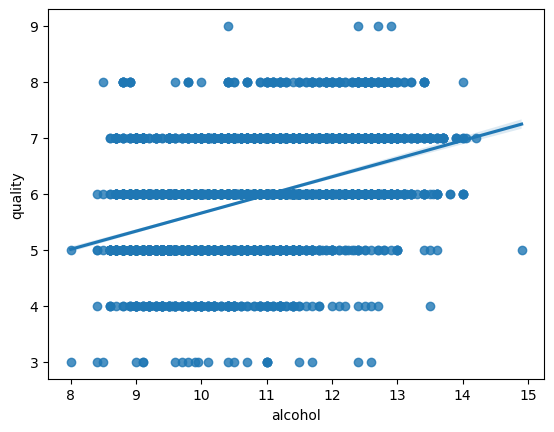

In [13]:
sns.regplot(x = combined_train_x['alcohol'], y = combined_train_y)

<AxesSubplot:xlabel='volatile acidity', ylabel='quality'>

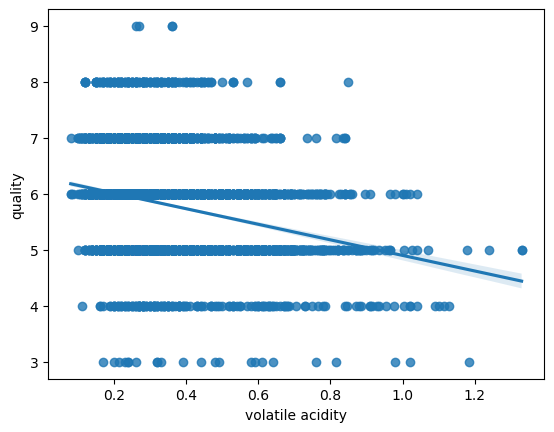

In [43]:
sns.regplot(x = combined_train_x['volatile acidity'], y = combined_train_y)

<AxesSubplot:xlabel='chlorides', ylabel='quality'>

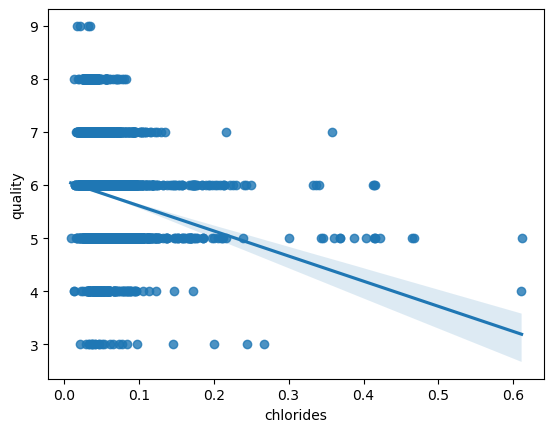

In [46]:
sns.regplot(x = combined_train_x['chlorides'], y = combined_train_y)

<AxesSubplot:xlabel='sulphates', ylabel='quality'>

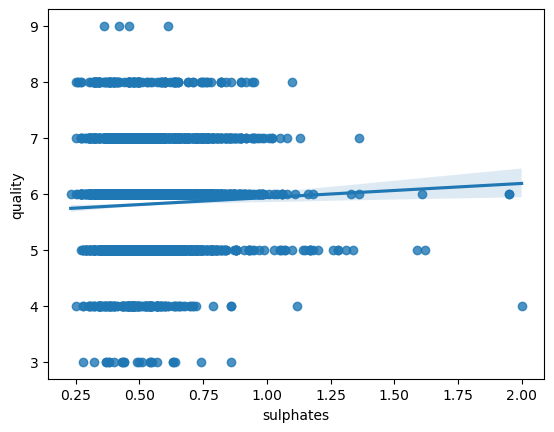

In [54]:
sns.regplot(x = combined_train_x['sulphates'], y = combined_train_y)

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### MARS
*By Cindy Wu*

In [128]:
# Coarse grid
# started off with wide range of values to iterate over

degrees = range(1,6)
maxterms = np.arange(10,100,20)

mse_scores_c = []

for deg in degrees:
    for term in maxterms:
        model = Earth(max_degree = deg, max_terms = term)
        cv = cross_validate(model, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error', n_jobs=-1)
        mse_scores_c.append(np.mean((-1*cv['test_score'])))

In [32]:
# these are the MAE scores, each row being a new degree and each column being a new term
reshaped = np.array(mse_scores_c).reshape(5,5)
reshaped_df = pd.DataFrame(reshaped)
reshaped_df # mean within each columns (for each term)

,0,1,2,3,4
0,0.748057,0.745158,0.745158,0.745158,0.745158
1,0.668113,0.913256,0.913256,0.913256,0.913256
2,0.749268,2.915438,1.338577,1.338577,1.338577
3,0.781334,1.093484,1.249860,1.249860,1.249860
4,0.781334,0.973922,0.966518,0.967365,0.967365


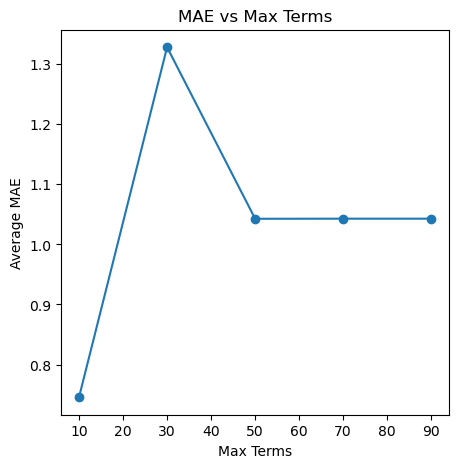

In [31]:
# averaged MAE values for each term across all 5 degree values
# used data visualization to identify ranges where the MAE was lowest
plt.figure(figsize=(5,5))
plt.scatter(maxterms, reshaped_df.mean(axis=0), zorder=1)
plt.plot(maxterms, reshaped_df.mean(axis=0), zorder=2)
plt.xlabel("Max Terms")
plt.ylabel("Average MAE")
plt.title('MAE vs Max Terms')
plt.show()


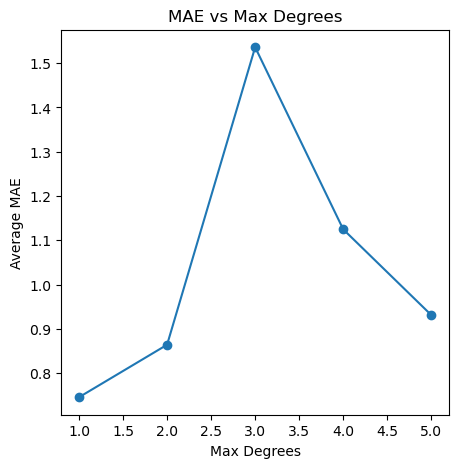

In [33]:
# used data visualization to identify ranges where the MAE was lowest
plt.figure(figsize=(5,5))
plt.scatter(degrees, reshaped_df.mean(axis=1), zorder=1)
plt.plot(degrees, reshaped_df.mean(axis=1), zorder=2)
plt.xlabel("Max Degrees")
plt.ylabel("Average MAE")
plt.title('MAE vs Max Degrees')
plt.show()

In [129]:
# Finer grid
# range 10 to 30 max_terms
# max degrees 1 to 3


degrees = range(1,3)
maxterms = np.arange(9,15,1)

mse_scores_c_t = []

for deg in degrees:
    for term in maxterms:
        model = Earth(max_degree = deg, max_terms = term)
        cv = cross_validate(model, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error', n_jobs=-1)
        mse_scores_c_t.append(np.mean((-1*cv['test_score'])))

In [37]:
# these are the MAE scores, each row being a new degree and each column being a new term
reshaped_t = np.array(mse_scores_c_t).reshape(2,6)
reshaped_df_t = pd.DataFrame(reshaped_t)
reshaped_df_t # mean within each columns (for each term)

,0,1,2,3,4,5
0,0.699651,0.748057,0.745158,0.745158,0.745158,0.745158
1,0.673808,0.668113,0.781456,0.781781,0.819273,0.848658


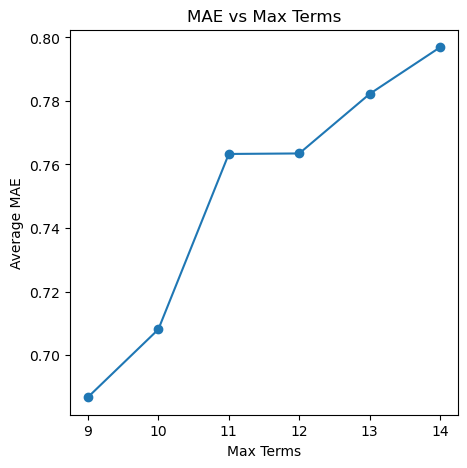

In [38]:
# averaged MAE values for each term across all 5 degree values
# used data visualization to identify ranges where the MAE was lowest
plt.figure(figsize=(5,5))
plt.scatter(maxterms, reshaped_df_t.mean(axis=0), zorder=1)
plt.plot(maxterms, reshaped_df_t.mean(axis=0), zorder=2)
plt.xlabel("Max Terms")
plt.ylabel("Average MAE")
plt.title('MAE vs Max Terms')
plt.show()

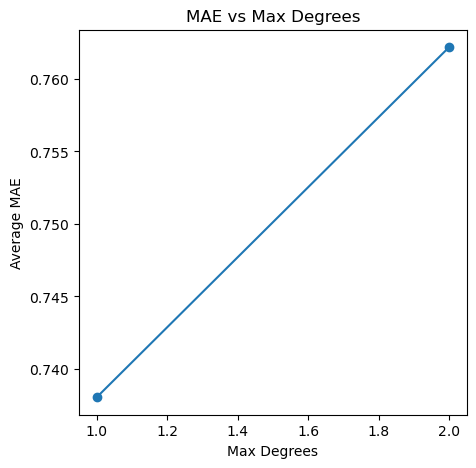

In [39]:
# used data visualization to identify ranges where the MAE was lowest
plt.figure(figsize=(5,5))
plt.scatter(degrees, reshaped_df_t.mean(axis=1), zorder=1)
plt.plot(degrees, reshaped_df_t.mean(axis=1), zorder=2)
plt.xlabel("Max Degrees")
plt.ylabel("Average MAE")
plt.title('MAE vs Max Degrees')
plt.show()

In [16]:
optimal_combined = Earth(max_degree = 1,max_terms=9, feature_importance_type = 'rss')
optimal_combined.fit(combined_train_x, combined_train_y)

y_pred_c = np.round(optimal_combined.predict(combined_test_x))
mse = mean_squared_error(combined_test_y, y_pred_c)
rmse = math.sqrt(mse)
print('RMSE for combined optimal model: ', rmse)
mae = mean_absolute_error(combined_test_y, y_pred_c)
print('MAE for combined optimal model: ', mae)

RMSE for combined optimal model:  0.7926586228053615
MAE for combined optimal model:  0.5163076923076924


### Bagged Decision Trees
*By Michael Kim*

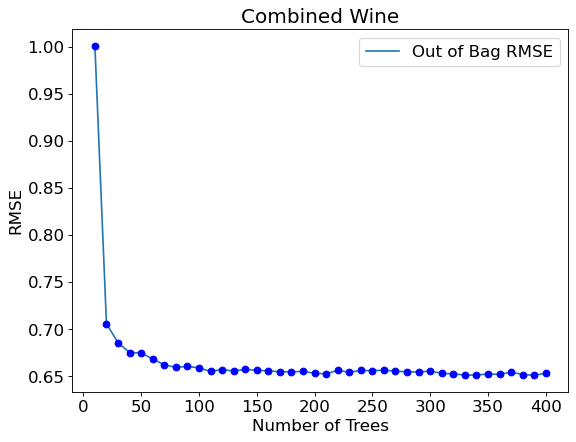

In [38]:
# Finding value of number of trees after which OOB RMSE doesn't decrease significantly
oob_rmse = {};
for i in np.linspace(10, 400, 40, dtype = int):
    model = BaggingRegressor(base_estimator = DecisionTreeRegressor(random_state = 1), n_estimators = i, random_state = 1,
                        n_jobs = -1, oob_score = True).fit(combined_train_x, combined_train_y)
    oob_rmse[i] = np.sqrt(mean_squared_error(np.rint(model.oob_prediction_), combined_train_y))
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (8, 6), dpi = 80)
plt.plot(list(oob_mae.keys()), list(oob_mae.values()), label = 'Out of Bag RMSE')
plt.plot(list(oob_mae.keys()), list(oob_mae.values()), 'o', color = 'blue')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Combined Wine')
plt.legend()

In [41]:
# Coarse grid for RMSE
params = {
    'n_estimators': [100],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

bagging_regressor_grid = GridSearchCV(
    BaggingRegressor(),
    param_grid = params,
    cv = cv,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 1
)

bagging_regressor_grid.fit(combined_train_x, combined_train_y)
print(-bagging_regressor_grid.best_score_)
print(bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.38545410180592854
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.75, 'max_samples': 0.75, 'n_estimators': 100}


In [42]:
# First fine grid for RMSE
params = {
    'n_estimators': [100],
    'max_samples': [0.8, 0.9, 1.0],
    'max_features': [0.5, 0.6, 0.7],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

bagging_regressor_grid = GridSearchCV(
    BaggingRegressor(),
    param_grid = params,
    cv = cv,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 1
)

bagging_regressor_grid.fit(combined_train_x, combined_train_y)
print(-bagging_regressor_grid.best_score_)
print(bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.3826996164060444
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.7, 'max_samples': 0.9, 'n_estimators': 100}


In [43]:
# Second fine grid for RMSE
params = {
    'n_estimators': [100],
    'max_samples': [0.95, 0.975, 1.0],
    'max_features': [0.55, 0.6, 0.65],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

bagging_regressor_grid = GridSearchCV(
    BaggingRegressor(),
    param_grid = params,
    cv = cv,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 1
)

bagging_regressor_grid.fit(combined_train_x, combined_train_y)
print(-bagging_regressor_grid.best_score_)
print(bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.3820702189596167
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.65, 'max_samples': 0.975, 'n_estimators': 100}


In [46]:
# Final fine grid for RMSE
params = {
    'n_estimators': [100],
    'max_samples': [0.985, 0.99, 0.995],
    'max_features': [0.625, 0.65, 0.675],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

bagging_regressor_grid = GridSearchCV(
    BaggingRegressor(),
    param_grid = params,
    cv = cv,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 1
)

bagging_regressor_grid.fit(combined_train_x, combined_train_y)
print(-bagging_regressor_grid.best_score_)
print(bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.3813010817617017
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.65, 'max_samples': 0.985, 'n_estimators': 100}


In [47]:
# Coarse grid for MAE
params = {
    'n_estimators': [100],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

bagging_regressor_grid = GridSearchCV(
    BaggingRegressor(),
    param_grid = params,
    cv = cv,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    verbose = 1
)

bagging_regressor_grid.fit(combined_train_x, combined_train_y)
print(-bagging_regressor_grid.best_score_)
print(bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.42240324751224134
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 100}


In [48]:
# First fine grid for MAE
params = {
    'n_estimators': [100],
    'max_samples': [0.8, 0.9, 1.0],
    'max_features': [0.5, 0.6, 0.7],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

bagging_regressor_grid = GridSearchCV(
    BaggingRegressor(),
    param_grid = params,
    cv = cv,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    verbose = 1
)

bagging_regressor_grid.fit(combined_train_x, combined_train_y)
print(-bagging_regressor_grid.best_score_)
print(bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.4220507007844995
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 100}


In [49]:
# Second fine grid for MAE
params = {
    'n_estimators': [100],
    'max_samples': [0.95, 0.975, 1.0],
    'max_features': [0.55, 0.6, 0.65],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

bagging_regressor_grid = GridSearchCV(
    BaggingRegressor(),
    param_grid = params,
    cv = cv,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    verbose = 1
)

bagging_regressor_grid.fit(combined_train_x, combined_train_y)
print(-bagging_regressor_grid.best_score_)
print(bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.4204062781024588
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.65, 'max_samples': 1.0, 'n_estimators': 100}


In [53]:
# Final fine grid for MAE
params = {
    'n_estimators': [100],
    'max_samples': [0.99, 0.995, 1.0],
    'max_features': [0.65, 0.675, 0.7],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

bagging_regressor_grid = GridSearchCV(
    BaggingRegressor(),
    param_grid = params,
    cv = cv,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    verbose = 1
)

bagging_regressor_grid.fit(combined_train_x, combined_train_y)
print(-bagging_regressor_grid.best_score_)
print(bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.4208858168799031
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.675, 'max_samples': 0.995, 'n_estimators': 100}


In [82]:
# Final bagged model for MAE with n_estimators increased to 400
final_bagged_model = BaggingRegressor(n_estimators = 400, max_samples = 0.995, max_features = 0.675, bootstrap = False,
                                     bootstrap_features = False).fit(combined_train_x, combined_train_y)
print('Test RMSE:', np.sqrt(mean_squared_error(np.round(final_bagged_model.predict(combined_test_x)), combined_test_y)))
print('Test MAE:', mean_absolute_error(np.round(final_bagged_model.predict(combined_test_x)), combined_test_y))

Test RMSE: 0.6591369648726572
Test MAE: 0.35938461538461536


In [6]:
# Final bagged model for RMSE with n_estimators increased to 400
final_bagged_model = BaggingRegressor(n_estimators = 400, max_samples = 0.99, max_features = 0.6, bootstrap = False,
                                     bootstrap_features = False).fit(combined_train_x, combined_train_y)
print('Test RMSE:', np.sqrt(mean_squared_error(np.round(final_bagged_model.predict(combined_test_x)), combined_test_y)))
print('Test MAE:', mean_absolute_error(np.round(final_bagged_model.predict(combined_test_x)), combined_test_y))

Test RMSE: 0.6600699263656145
Test MAE: 0.3618461538461539


### Random forest
*By Sabrina Kozarovitsky*

In [130]:
#Coarse Grid
n_samples = combined_train_x.shape[0]
n_features = combined_train_x.shape[1]

params = {'n_estimators': [1000, 1350],
          'max_features': list(range(2,8,2)),
          'max_depth': [None,15,18],
          'max_leaf_nodes':[700,1000,1300],
          'bootstrap': [True, False]}

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rf_regressor_grid = GridSearchCV(RandomForestRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')
rf_regressor_grid.fit(combined_train_x, combined_train_y)
print('Best Parameters : ',rf_regressor_grid.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters :  {'bootstrap': False, 'max_depth': None, 'max_features': 2, 'max_leaf_nodes': 1300, 'n_estimators': 1000}


In [131]:
#Finer Grid
n_samples = combined_train_x.shape[0]
n_features = combined_train_x.shape[1]

params = {'n_estimators': [900, 1000, 1050, 1100],
          'max_features': [1, 2],
          'max_depth': [None],
          'max_leaf_nodes':[1000,1300],
          'bootstrap': [True, False]}

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rf_regressor_grid = GridSearchCV(RandomForestRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')
rf_regressor_grid.fit(combined_train_x, combined_train_y)
print('Best Parameters : ',rf_regressor_grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters :  {'bootstrap': False, 'max_depth': None, 'max_features': 2, 'max_leaf_nodes': 1300, 'n_estimators': 900}


In [132]:
#Even Finer Grid
n_samples = combined_train_x.shape[0]
n_features = combined_train_x.shape[1]

params = {'n_estimators': [900,925, 950, 1000],
          'max_features': [2],
          'max_depth': [None],
          'max_leaf_nodes':[1300],
          'bootstrap': [True, False]}

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rf_regressor_grid = GridSearchCV(RandomForestRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')
rf_regressor_grid.fit(combined_train_x, combined_train_y)
print('Best Parameters : ',rf_regressor_grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters :  {'bootstrap': False, 'max_depth': None, 'max_features': 2, 'max_leaf_nodes': 1300, 'n_estimators': 925}


In [133]:
#Last Finer Grid
n_samples = combined_train_x.shape[0]
n_features = combined_train_x.shape[1]

params = {'n_estimators': list(range(900,930,2)),
          'max_features': [2],
          'max_depth': [None],
          'max_leaf_nodes':[1300],
          'bootstrap': [True, False]}

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rf_regressor_grid = GridSearchCV(RandomForestRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')
rf_regressor_grid.fit(combined_train_x, combined_train_y)
print('Best Parameters : ',rf_regressor_grid.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters :  {'bootstrap': False, 'max_depth': None, 'max_features': 2, 'max_leaf_nodes': 1300, 'n_estimators': 910}


In [8]:
# Combined Model with optimal parameters
optimal_model_combined = RandomForestRegressor(n_estimators=910, random_state=1, max_features = 2, bootstrap = False, max_leaf_nodes = 1300).fit(combined_train_x, combined_train_y)

y_pred = optimal_model_combined.predict(combined_test_x)

#RMSE on test data
print("RMSE:",np.sqrt(mean_squared_error(combined_test_y, y_pred)))
#MAE on test data
print("MAE:",mean_absolute_error(combined_test_y, y_pred))

RMSE: 0.590783368563015
MAE: 0.41618324873019213


In [9]:
# combined Model + ROUNDING
y_pred_rounded = np.rint(y_pred)

#RMSE on test data
print("RMSE:",np.sqrt(mean_squared_error(combined_test_y, y_pred_rounded)))
#MAE on test data
print("MAE:",mean_absolute_error(combined_test_y, y_pred_rounded))

RMSE: 0.6421119001448987
MAE: 0.3483076923076923


<AxesSubplot:xlabel='quality', ylabel='pred_y_rounded'>

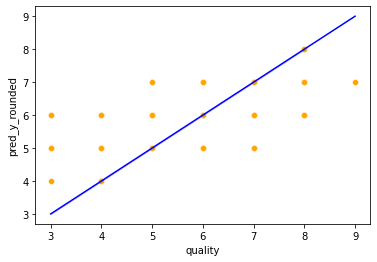

In [19]:
pred_vs_acc = pd.concat([(pd.DataFrame(y_pred_rounded, columns=["pred_y_rounded"])), combined_test_y], axis = 1)
sns.scatterplot(x = 'quality', y = 'pred_y_rounded', data = pred_vs_acc, color = 'orange')
sns.lineplot(x = 'quality', y = 'quality', data = pred_vs_acc, color = 'blue')

### XGBoost
*By Keaton Olds*

In [35]:
#coarse grid search with wide ranges

param_grid = {'max_depth': [4,6,8],
              'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.5, 0.75, 1],
              'colsample_bytree': [0.5, 0.75, 1],
              'reg_lambda':[0, 1, 10],
              'gamma': [0, 10, 100]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid,
                                 n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_squared_error')
grid_result_coarse = grid_search.fit(combined_train_x, combined_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result_coarse.best_score_), grid_result_coarse.best_params_))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best: 0.624159 using {'subsample': 1, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}


In [36]:
#collect results of coarse grid to visualize
cv_results_coarse = pd.DataFrame(grid_result_coarse.cv_results_)

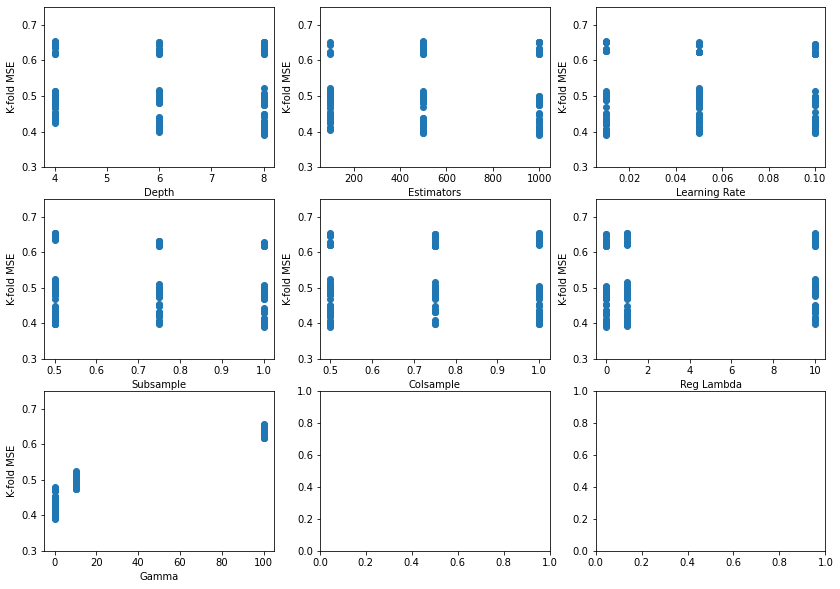

In [37]:
#visualize how RMSE changes with values of the hyperparamteres
fig, axes = plt.subplots(3,3,figsize=(14,10))
plt.subplots_adjust(wspace=0.2)
axes[0,0].plot(cv_results_coarse.param_max_depth, -cv_results_coarse.mean_test_score, 'o')
axes[0,0].set_ylim([0.3, 0.75])
axes[0,0].set_xlabel('Depth')
axes[0,0].set_ylabel('K-fold MSE')
axes[0,1].plot(cv_results_coarse.param_n_estimators, -cv_results_coarse.mean_test_score, 'o')
axes[0,1].set_ylim([0.3, 0.75])
axes[0,1].set_xlabel('Estimators')
axes[0,1].set_ylabel('K-fold MSE')
axes[0,2].plot(cv_results_coarse.param_learning_rate, -cv_results_coarse.mean_test_score, 'o')
axes[0,2].set_ylim([0.3, 0.75])
axes[0,2].set_xlabel('Learning Rate')
axes[0,2].set_ylabel('K-fold MSE')
axes[1,0].plot(cv_results_coarse.param_subsample, -cv_results_coarse.mean_test_score, 'o')
axes[1,0].set_ylim([0.3, 0.75])
axes[1,0].set_xlabel('Subsample')
axes[1,0].set_ylabel('K-fold MSE')
axes[1,1].plot(cv_results_coarse.param_colsample_bytree, -cv_results_coarse.mean_test_score, 'o')
axes[1,1].set_ylim([0.3, 0.75])
axes[1,1].set_xlabel('Colsample')
axes[1,1].set_ylabel('K-fold MSE')
axes[1,2].plot(cv_results_coarse.param_reg_lambda, -cv_results_coarse.mean_test_score, 'o')
axes[1,2].set_ylim([0.3, 0.75])
axes[1,2].set_xlabel('Reg Lambda')
axes[1,2].set_ylabel('K-fold MSE')
axes[2,0].plot(cv_results_coarse.param_gamma, -cv_results_coarse.mean_test_score, 'o')
axes[2,0].set_ylim([0.3, 0.75])
axes[2,0].set_xlabel('Gamma')
axes[2,0].set_ylabel('K-fold MSE');

In [38]:
#fine grid search

param_grid = {'max_depth': [8,9,10,11,12],
              'n_estimators': [1000],
              'learning_rate': [0.01, 0.03, 0.05],
              'subsample': [1],
              'colsample_bytree': [0.5],
              'reg_lambda':[0,2,4,6,8],
              'gamma': [0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_squared_error')
grid_result_fine = grid_search.fit(combined_train_x, combined_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result_fine.best_score_), grid_result_fine.best_params_))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best: 0.615033 using {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 1000, 'reg_lambda': 2, 'subsample': 1}


In [39]:
#collect results of fine grid search to visualize
cv_results_fine = pd.DataFrame(grid_result_fine.cv_results_)

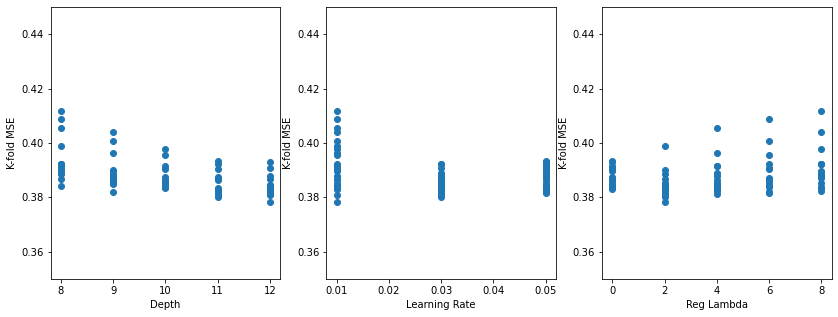

In [40]:
#visualize how RMSE changes with the values of max_depth, n_estimators, and reg_lambda in the fine search
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results_fine.param_max_depth, -cv_results_fine.mean_test_score, 'o')
axes[0].set_ylim([0.35, 0.45])
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold MSE')
axes[1].plot(cv_results_fine.param_learning_rate, -cv_results_fine.mean_test_score, 'o')
axes[1].set_ylim([0.35, 0.45])
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('K-fold MSE')
axes[2].plot(cv_results_fine.param_reg_lambda, -cv_results_fine.mean_test_score, 'o')
axes[2].set_ylim([0.35, 0.45])
axes[2].set_xlabel('Reg Lambda')
axes[2].set_ylabel('K-fold MSE');

In [46]:
#model from grid searches on TRAIN data
combined_model_tuned = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.01, max_depth = 12, n_estimators = 1000,
                                  reg_lambda = 2, subsample = 1, colsample_bytree = 0.5).fit(combined_train_x, combined_train_y)
mae = mean_absolute_error(combined_train_y, np.around(combined_model_tuned.predict(combined_train_x)))
rmse = np.sqrt(mean_squared_error(combined_train_y, np.around(combined_model_tuned.predict(combined_train_x))))

print('Train RMSE for combined tuned model: ', rmse)
print('Train MAE for combined tuned model: ', mae)

Train RMSE for combined tuned model:  0.06565321642986127
Train MAE for combined tuned model:  0.004310344827586207


>0.0100 2.1 (0.0)
>0.0200 1.0 (0.0)
>0.0300 0.7 (0.0)
>0.0400 0.7 (0.0)
>0.0500 0.7 (0.0)
>0.0600 0.7 (0.0)
>0.0700 0.7 (0.0)
>0.0800 0.7 (0.0)
>0.0900 0.6 (0.0)


Text(0.5, 0, 'Learning rate')

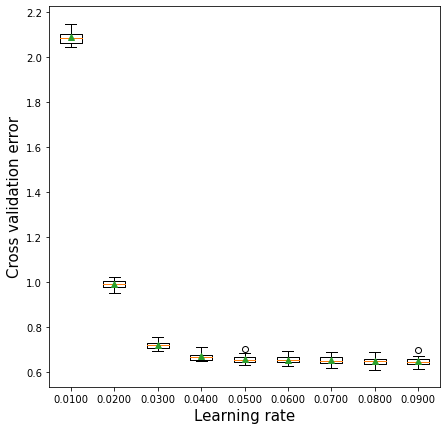

In [69]:
#visualize learning rate in order to manually tune it
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, combined_train_x, combined_train_y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

In [72]:
#manually tune learning_rate
combined_model_tuned = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.05, max_depth = 12, n_estimators = 1000,
                                  reg_lambda = 2, subsample = 1, colsample_bytree = 0.5).fit(combined_train_x, combined_train_y)
mae = mean_absolute_error(combined_train_y, np.around(combined_model_tuned.predict(combined_train_x)))
rmse = np.sqrt(mean_squared_error(combined_train_y, np.around(combined_model_tuned.predict(combined_train_x))))

print('Train RMSE for combined tuned model: ', rmse)
print('Train MAE for combined tuned model: ', mae)

Train RMSE for combined tuned model:  0.0
Train MAE for combined tuned model:  0.0


In [73]:
#Optimal train model on test data
combined_model_tuned = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.05, max_depth = 12, n_estimators = 1000,
                                  reg_lambda = 2, subsample = 1, colsample_bytree = 0.5).fit(combined_train_x, combined_train_y)
mae = mean_absolute_error(combined_test_y, np.around(combined_model_tuned.predict(combined_test_x)))
rmse = np.sqrt(mean_squared_error(combined_test_y, np.around(combined_model_tuned.predict(combined_test_x))))

print('Test RMSE for combined tuned model: ', rmse)
print('Test MAE for combined tuned model: ', mae)

Test RMSE for combined tuned model:  0.6567987632331652
Test MAE for combined tuned model:  0.36


In [75]:
#Adjust model for overfitting
combined_model_tuned = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.05, max_depth = 11, n_estimators = 300,
                                  reg_lambda = 2, subsample = 0.75, colsample_bytree = 0.5).fit(combined_train_x, combined_train_y)
mae = mean_absolute_error(combined_train_y, np.around(combined_model_tuned.predict(combined_train_x)))
rmse = np.sqrt(mean_squared_error(combined_train_y, np.around(combined_model_tuned.predict(combined_train_x))))

print('Train RMSE for combined tuned model: ', rmse)
print('Train MAE for combined tuned model: ', mae)

Train RMSE for combined tuned model:  0.01432670637653132
Train MAE for combined tuned model:  0.00020525451559934318


In [10]:
#Adjust model for overfitting
combined_model_tuned = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.05, max_depth = 11, n_estimators = 300,
                                  reg_lambda = 2, subsample = 0.75, colsample_bytree = 0.5).fit(combined_train_x, combined_train_y)
mae = mean_absolute_error(combined_test_y, np.around(combined_model_tuned.predict(combined_test_x)))
rmse = np.sqrt(mean_squared_error(combined_test_y, np.around(combined_model_tuned.predict(combined_test_x))))

print('RMSE for combined tuned model: ', rmse)
print('MAE for combined tuned model: ', mae)

RMSE for combined tuned model:  0.6440257997698778
MAE for combined tuned model:  0.3507692307692308


## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble
*By Michael Kim*

Because we cannot use the results on test data to find the best model, we used cross-validated metrics to find the best voting ensemble model performance and then compared it to how it performed to test data to see if it did in fact find the best model or not. We also tested removing the worst performing model until only two models remained, in addition to adding a LinearRegression() model for diversity.

In [73]:
en = VotingRegressor(estimators = [('xgb', combined_model_tuned), ('dt', final_bagged_model), 
                                   ('rf', optimal_model_combined), ('mars', optimal_combined),
                                   ('linear', LinearRegression().fit(combined_train_x, combined_train_y))])
mse_scores = np.mean(-cross_val_score(en, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error'))
mae_scores = np.mean(-cross_val_score(en, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_absolute_error'))
print("Ensemble Model CV RMSE = ", np.sqrt(mse_scores))
print("Ensemble Model CV MAE = ", mae_scores)

Ensemble Model CV RMSE =  0.800562554315018
Ensemble Model CV MAE =  0.6024538529284872


In [74]:
en = VotingRegressor(estimators = [('xgb', combined_model_tuned), ('dt', final_bagged_model), 
                                   ('rf', optimal_model_combined), ('mars', optimal_combined)])
mse_scores = np.mean(-cross_val_score(en, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error'))
mae_scores = np.mean(-cross_val_score(en, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_absolute_error'))
print("Ensemble Model CV RMSE = ", np.sqrt(mse_scores))
print("Ensemble Model CV MAE = ", mae_scores)

Ensemble Model CV RMSE =  0.8141903714356976
Ensemble Model CV MAE =  0.5991138701410593


In [75]:
en = VotingRegressor(estimators = [('xgb', combined_model_tuned), ('dt', final_bagged_model), 
                                   ('rf', optimal_model_combined)])
mse_scores = np.mean(-cross_val_score(en, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error'))
mae_scores = np.mean(-cross_val_score(en, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_absolute_error'))
print("Ensemble Model CV RMSE = ", np.sqrt(mse_scores))
print("Ensemble Model CV MAE = ", mae_scores)

Ensemble Model CV RMSE =  0.784794317025434
Ensemble Model CV MAE =  0.5606940275635554


In [76]:
en = VotingRegressor(estimators = [('xgb', combined_model_tuned), ('rf', optimal_model_combined)])
mse_scores = np.mean(-cross_val_score(en, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error'))
mae_scores = np.mean(-cross_val_score(en, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_absolute_error'))
print("Ensemble Model CV RMSE = ", np.sqrt(mse_scores))
print("Ensemble Model CV MAE = ", mae_scores)

Ensemble Model CV RMSE =  0.8096109025854821
Ensemble Model CV MAE =  0.5771340766632412


In [77]:
en = VotingRegressor(estimators = [('xgb', combined_model_tuned), ('dt', final_bagged_model), 
                                   ('rf', optimal_model_combined), ('mars', optimal_combined),
                                   ('linear', LinearRegression().fit(combined_train_x, combined_train_y))])
en.fit(combined_train_x, combined_train_y)
print("Ensemble Model Test RMSE = ", np.sqrt(mean_squared_error(np.round(en.predict(combined_test_x)), combined_test_y)))
print("Ensemble Model Test MAE = ", mean_absolute_error(np.round(en.predict(combined_test_x)), combined_test_y))

Ensemble Model Test RMSE =  0.6784597941718377
Ensemble Model Test MAE =  0.384


In [78]:
en = VotingRegressor(estimators = [('xgb', combined_model_tuned), ('dt', final_bagged_model), 
                                   ('rf', optimal_model_combined), ('mars', optimal_combined)])
en.fit(combined_train_x, combined_train_y)
print("Ensemble Model Test RMSE = ", np.sqrt(mean_squared_error(np.round(en.predict(combined_test_x)), combined_test_y)))
print("Ensemble Model Test MAE = ", mean_absolute_error(np.round(en.predict(combined_test_x)), combined_test_y))

Ensemble Model Test RMSE =  0.6567987632331652
Ensemble Model Test MAE =  0.3575384615384615


In [83]:
en = VotingRegressor(estimators = [('xgb', combined_model_tuned), ('dt', final_bagged_model), 
                                   ('rf', optimal_model_combined)])
en.fit(combined_train_x, combined_train_y)
print("Ensemble Model Test RMSE = ", np.sqrt(mean_squared_error(np.round(en.predict(combined_test_x)), combined_test_y)))
print("Ensemble Model Test MAE = ", mean_absolute_error(np.round(en.predict(combined_test_x)), combined_test_y))

Ensemble Model Test RMSE =  0.6387487769068525
Ensemble Model Test MAE =  0.3464615384615385


In [80]:
en = VotingRegressor(estimators = [('xgb', combined_model_tuned),
                                   ('rf', optimal_model_combined)])
en.fit(combined_train_x, combined_train_y)
print("Ensemble Model Test RMSE = ", np.sqrt(mean_squared_error(np.round(en.predict(combined_test_x)), combined_test_y)))
print("Ensemble Model Test MAE = ", mean_absolute_error(np.round(en.predict(combined_test_x)), combined_test_y))

Ensemble Model Test RMSE =  0.637784627260042
Ensemble Model Test MAE =  0.34523076923076923


Although the VotingRegressor() with just XGBRegressor() and RandomForestRegressor() actually yielded lower test RMSE and test MAE than any individual model, our CV metrics did not choose this as the best model. As a result, the one that was selected as best by CV metrics was the VotingRegressor() with XGBRegressor(), RandomForestRegressor(), and BaggingRegressor(), which had a lower test RMSE and MAE than individual models still.

### Stacking ensemble(s)

*Linear Regression by Michael Kim*

In [93]:
en_linear = StackingRegressor(estimators = [('xgb', combined_model_tuned), ('dt', final_bagged_model), 
                                   ('rf', optimal_model_combined), ('mars', optimal_combined),
                                    ('linear', LinearRegression().fit(combined_train_x, combined_train_y))], 
                       final_estimator = LinearRegression(), cv = KFold(n_splits = 3, 
                                                                             shuffle = True, random_state = 1))
mse_scores = np.mean(-cross_val_score(en_linear, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error'))
mae_scores = np.mean(-cross_val_score(en_linear, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_absolute_error'))
en_linear.fit(combined_train_x, combined_train_y)
print("Ensemble Model CV RMSE = ", np.sqrt(mse_scores))
print("Ensemble Model CV MAE = ", mae_scores)
print("Ensemble Model Test RMSE = ", np.sqrt(mean_squared_error(np.round(en_linear.predict(combined_test_x)), combined_test_y)))
print("Ensemble Model Test MAE = ", mean_absolute_error(np.round(en_linear.predict(combined_test_x)), combined_test_y))

Ensemble Model CV RMSE =  0.7492354171358657
Ensemble Model CV MAE =  0.5465082563383507
Ensemble Model Test RMSE =  0.6397114734243629
Ensemble Model Test MAE =  0.3464615384615385


*MARS by Cindy Wu*

In [96]:
en_mars = StackingRegressor(estimators = [('xgb', combined_model_tuned), ('dt', final_bagged_model), 
                                   ('rf', optimal_model_combined), ('mars', optimal_combined),
                                    ('linear', LinearRegression().fit(combined_train_x, combined_train_y))], 
                       final_estimator = Earth(max_degree = 1), cv = KFold(n_splits = 3, 
                                                                             shuffle = True, random_state = 1))
mse_scores = np.mean(-cross_val_score(en_mars, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error'))
mae_scores = np.mean(-cross_val_score(en_mars, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_absolute_error'))
en_mars.fit(combined_train_x, combined_train_y)
print("Ensemble Model CV RMSE = ", np.sqrt(mse_scores))
print("Ensemble Model CV MAE = ", mae_scores)
print("Ensemble Model Test RMSE = ", np.sqrt(mean_squared_error(np.round(en_mars.predict(combined_test_x)), combined_test_y)))
print("Ensemble Model Test MAE = ", mean_absolute_error(np.round(en_mars.predict(combined_test_x)), combined_test_y))

Ensemble Model CV RMSE =  0.7532222825982855
Ensemble Model CV MAE =  0.5488166656991543
Ensemble Model Test RMSE =  0.6397114734243629
Ensemble Model Test MAE =  0.3464615384615385


*Random Forest By Sabrina Kozarovitsky*

In [120]:
en_rf = StackingRegressor(estimators = [('xgb', combined_model_tuned), ('dt', final_bagged_model), 
                                   ('rf', optimal_model_combined), ('mars', optimal_combined),
                                    ('linear', LinearRegression().fit(combined_train_x, combined_train_y))], 
                       final_estimator = RandomForestRegressor(), cv = KFold(n_splits = 3, 
                                                                             shuffle = True, random_state = 1))
grid_search_rf = GridSearchCV(estimator = en_rf, param_grid = {'final_estimator__max_samples': [0.5, 0.7, 0.9]},
    scoring = 'neg_mean_squared_error', 
    cv = 3)
grid_search_rf.fit(combined_train_x, combined_train_y)
en_rf = grid_search_rf.best_estimator_
mse_scores = np.mean(-cross_val_score(en_rf, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error'))
mae_scores = np.mean(-cross_val_score(en_rf, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_absolute_error'))
en_rf.fit(combined_train_x, combined_train_y)
print("Ensemble Model CV RMSE = ", np.sqrt(mse_scores))
print("Ensemble Model CV MAE = ", mae_scores)
print("Ensemble Model Test RMSE = ", np.sqrt(mean_squared_error(np.round(en_rf.predict(combined_test_x)), combined_test_y)))
print("Ensemble Model Test MAE = ", mean_absolute_error(np.round(en_rf.predict(combined_test_x)), combined_test_y))

Ensemble Model CV RMSE =  0.8162896904805874
Ensemble Model CV MAE =  0.5936781609195402
Ensemble Model Test RMSE =  0.6647150922358795
Ensemble Model Test MAE =  0.3618461538461539


*XGBRegressor By Keaton Olds*

In [114]:
en_xgb = StackingRegressor(estimators = [('xgb', combined_model_tuned), ('dt', final_bagged_model), 
                                   ('rf', optimal_model_combined), ('mars', optimal_combined),
                                    ('linear', LinearRegression().fit(combined_train_x, combined_train_y))], 
                       final_estimator = xgb.XGBRegressor(), cv = KFold(n_splits = 3, 
                                                                             shuffle = True, random_state = 1))
mse_scores = np.mean(-cross_val_score(en_xgb, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error'))
mae_scores = np.mean(-cross_val_score(en_xgb, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_absolute_error'))
en_xgb.fit(combined_train_x, combined_train_y)
print("Ensemble Model CV RMSE = ", np.sqrt(mse_scores))
print("Ensemble Model CV MAE = ", mae_scores)
print("Ensemble Model Test RMSE = ", np.sqrt(mean_squared_error(np.round(en_xgb.predict(combined_test_x)), combined_test_y)))
print("Ensemble Model Test MAE = ", mean_absolute_error(np.round(en_xgb.predict(combined_test_x)), combined_test_y))

Ensemble Model CV RMSE =  0.8639572409667655
Ensemble Model CV MAE =  0.6398671255714592
Ensemble Model Test RMSE =  0.6892582412107403
Ensemble Model Test MAE =  0.38769230769230767


### Ensemble of ensembled models

In [123]:
en_en_mars = StackingRegressor(estimators = [('xgb', en_xgb), 
                                   ('rf', en_rf), ('mars', en_mars),
                                    ('linear', en_linear)], 
                       final_estimator = Earth(max_degree = 1), cv = KFold(n_splits = 3, 
                                                                             shuffle = True, random_state = 1))
mse_scores = np.mean(-cross_val_score(en_en_mars, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_squared_error'))
mae_scores = np.mean(-cross_val_score(en_en_mars, combined_train_x, combined_train_y, cv = 3, scoring = 'neg_mean_absolute_error'))
en_en_mars.fit(combined_train_x, combined_train_y)
print("Ensemble Model CV RMSE = ", np.sqrt(mse_scores))
print("Ensemble Model CV MAE = ", mae_scores)
print("Ensemble Model Test RMSE = ", np.sqrt(mean_squared_error(np.round(en_en_mars.predict(combined_test_x)), combined_test_y)))
print("Ensemble Model Test MAE = ", mean_absolute_error(np.round(en_en_mars.predict(combined_test_x)), combined_test_y))

Ensemble Model CV RMSE =  nan
Ensemble Model CV MAE =  nan
Ensemble Model Test RMSE =  0.6406727233631369
Ensemble Model Test MAE =  0.3464615384615385


The above cross-validated metrics being nan can be ignored for our purposes (as if they were deleted from the code) since we only used one model, which was MARS that was ideal for previous StackingRegressor() as metamodel. 

### Feature Importances

*By Sabrina Kozarovitsky*

In [17]:
#importances from final MARS model
feature_importances = optimal_combined.feature_importances_
importances_df = pd.DataFrame({'Feature':combined_train_x.columns, 'Importance': feature_importances})
importances_df.sort_values(by="Importance",ascending = False)

,Feature,Importance
10,alcohol,0.693000
1,volatile acidity,0.194095
6,total sulfur dioxide,0.035347
3,residual sugar,0.029388
9,sulphates,0.025119
5,free sulfur dioxide,0.023051
0,fixed acidity,0.000000
2,citric acid,0.000000
4,chlorides,0.000000
7,density,0.000000


In [21]:
#importances from bagged dt
feature_importances = np.mean([tree.feature_importances_ for tree in final_bagged_model.estimators_], axis = 0)
preds = combined_test_x.columns

importances_df = pd.DataFrame([preds,feature_importances]).transpose()
importances_df.columns = ["Feature", "Importance"]
importances_df.sort_values(by="Importance",ascending = False)

,Feature,Importance
1,volatile acidity,0.153734
3,residual sugar,0.149638
5,free sulfur dioxide,0.14313
2,citric acid,0.139111
0,fixed acidity,0.138574
6,total sulfur dioxide,0.138142
4,chlorides,0.137671
7,density,None
8,pH,None
9,sulphates,None


In [19]:
#importances from RandomForest
feature_importances = optimal_model_combined.feature_importances_
importances_df = pd.DataFrame({'Feature':combined_train_x.columns, 'Importance': feature_importances})
importances_df.sort_values(by="Importance",ascending = False)

,Feature,Importance
10,alcohol,0.170356
7,density,0.115057
1,volatile acidity,0.103412
4,chlorides,0.087753
5,free sulfur dioxide,0.081999
6,total sulfur dioxide,0.081463
2,citric acid,0.074984
9,sulphates,0.073781
3,residual sugar,0.073573
8,pH,0.065316


In [20]:
#importances from XGBoost
feature_importances = combined_model_tuned.feature_importances_
importances_df = pd.DataFrame({'Feature':combined_train_x.columns, 'Importance': feature_importances})
importances_df.sort_values(by="Importance",ascending = False)

,Feature,Importance
10,alcohol,0.170068
12,type_white,0.161298
11,type_red,0.134862
7,density,0.066809
9,sulphates,0.065964
5,free sulfur dioxide,0.060513
8,pH,0.060295
4,chlorides,0.053879
3,residual sugar,0.052179
6,total sulfur dioxide,0.051099


Alcohol seens to be the most important predictor while the importance of other predictors varies across models.